# Model training with Turi Create

Another tool for image classification (among other uses) is Turi Create. This gives developers more control over the model than CreateML. In this Notebook I'll recreate the model that I created with CreateML, using SqueezeNet (as it's still small enough to use in mobile devices).

This next section is seting up the Notebook, I'm using Google Colab, so all the training, validation and testing data is in GDrive.


In [ ]:
import numpy as np

!pip install turicreate
import turicreate as tc
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

I'll load the training and testing data, and then let Turi extract the features. TuriCreate extracts 1000 features per image

In [ ]:
train_data = tc.image_analysis.load_images("/content/gdrive/MyDrive/Colab Notebooks/snacks/train", with_path=True)
len(train_data)

test_data = tc.image_analysis.load_images("/content/gdrive/MyDrive/Colab Notebooks/snacks/test", with_path=True)
len(test_data)

import os
train_data["label"] = train_data["path"].apply(
              lambda path: os.path.basename(os.path.split(path)[0]))

test_data["label"] = test_data["path"].apply(
              lambda path: os.path.basename(os.path.split(path)[0]))

train_data["label"].value_counts().print_rows(num_rows=20)
test_data["label"].value_counts().print_rows(num_rows=20)

Testing if the images were loaded correctly:

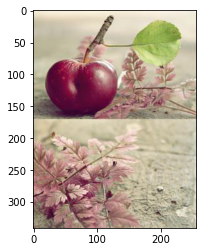

In [6]:
plt.imshow(train_data[0]["image"].pixel_data)

In [7]:
train_data["label"] = train_data["path"].apply(lambda path:os.path.basename(os.path.split(path)[0]))

In [8]:
train_data["label"].summary()


+------------------+-------+----------+
|       item       | value | is exact |
+------------------+-------+----------+
|      Length      |  4860 |   Yes    |
| # Missing Values |   0   |   Yes    |
| # unique values  |   20  |    No    |
+------------------+-------+----------+

Most frequent items:
+------------+-------+
|   value    | count |
+------------+-------+
|   apple    |  270  |
| pineapple  |  260  |
| strawberry |  251  |
|   banana   |  250  |
|  doughnut  |  250  |
|   grape    |  250  |
|  hot dog   |  250  |
| ice cream  |  250  |
|   juice    |  250  |
|   muffin   |  250  |
+------------+-------+


To check how the clasifier did we can get some metrics such as accuracy (overall correctness), precision (how good it is at a particular category) and recall (amount of times it got a category correctly):

In [ ]:
model = tc.image_classifier.create(train_data, target="label", model="squeezenet_v1.1", verbose=True, max_iterations=100)

In [10]:
metrics = model.evaluate(test_data)
print("Accuracy: ", metrics["accuracy"])
print("Precision: ", metrics["precision"])
print("Recall: ", metrics["recall"])

Performing feature extraction on resized images...
Completed  64/986
Completed 128/986
Completed 192/986
Completed 256/986
Completed 320/986
Completed 384/986
Completed 448/986
Completed 512/986
Completed 576/986
Completed 640/986
Completed 704/986
Completed 768/986
Completed 832/986
Completed 896/986
Completed 960/986
Completed 986/986
Accuracy:  0.652129817444219
Precision:  0.652751221531225
Recall:  0.649753114554249


The classifier had some troubles, here we can see how it classified apples as oranges, or bananas as pineapples, for example. This could be solved by having more and/or better images for training:

In [ ]:
output = model.classify(test_data)
output

imgs_with_pred = test_data.add_columns(output)
imgs_with_pred.explore()

,path,image,label,class,probability
0,/content/gdrive/MyDrive/Colab Notebooks/snacks/test/banana/0fb15f6f8289bf78.jpg,,banana,pineapple,0.924027
1,/content/gdrive/MyDrive/Colab Notebooks/snacks/test/banana/33e2d11aef91defb.jpg,,banana,hot dog,0.986924
2,/content/gdrive/MyDrive/Colab Notebooks/snacks/test/cake/ba0269590f729b08.jpg,,cake,hot dog,0.934264
3,/content/gdrive/MyDrive/Colab Notebooks/snacks/test/candy/0f4aa7ed9302d084.jpg,,candy,strawberry,0.952603
4,/content/gdrive/MyDrive/Colab Notebooks/snacks/test/candy/20d938b9cc57b4bd.jpg,,candy,strawberry,0.977409
5,/content/gdrive/MyDrive/Colab Notebooks/snacks/test/carrot/4acc22aee75c473b.jpg,,carrot,orange,0.901586
6,/content/gdrive/MyDrive/Colab Notebooks/snacks/test/cookie/50d60abbaffa1e9e.jpg,,cookie,muffin,0.949373
7,/content/gdrive/MyDrive/Colab Notebooks/snacks/test/cookie/62c898713b2ac490.jpg,,cookie,muffin,0.966519
8,/content/gdrive/MyDrive/Colab Notebooks/snacks/test/cookie/cc63fda88e312550.jpg,,cookie,cake,0.969885
9,/content/gdrive/MyDrive/Colab Notebooks/snacks/test/doughnut/314538a633c0ab92.jpg,,doughnut,cookie,0.988889

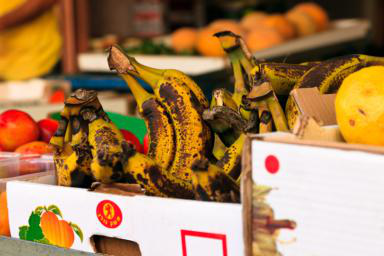
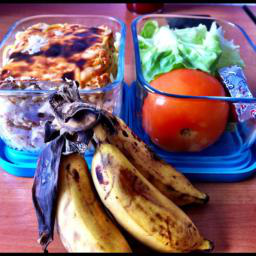
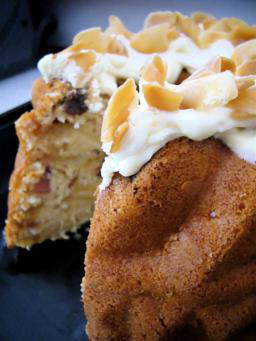
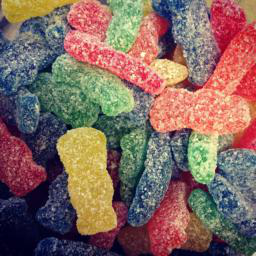
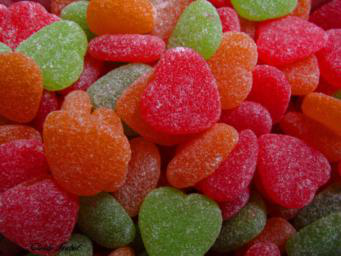
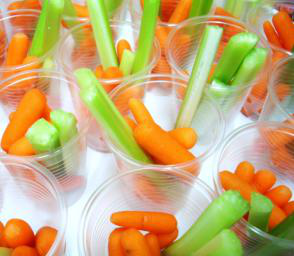
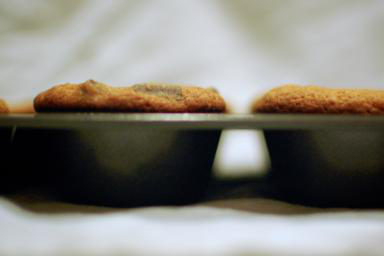
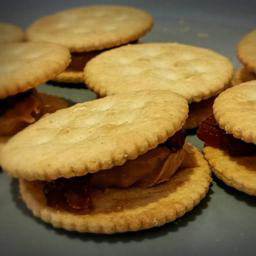
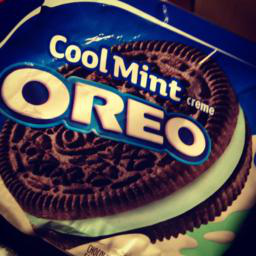
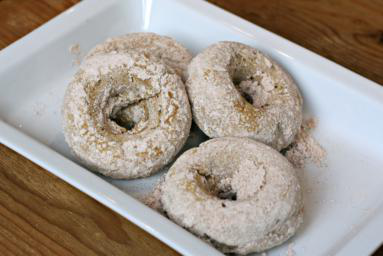
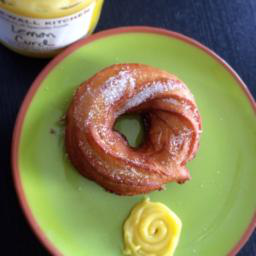
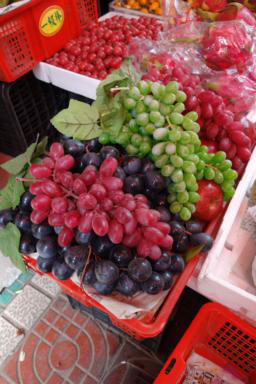
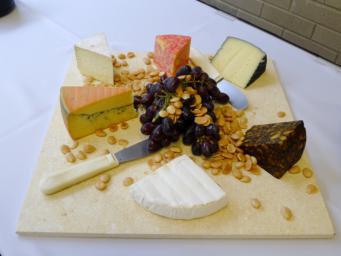
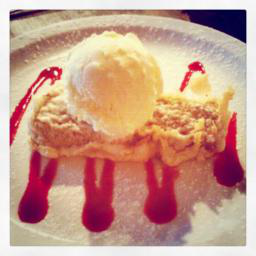
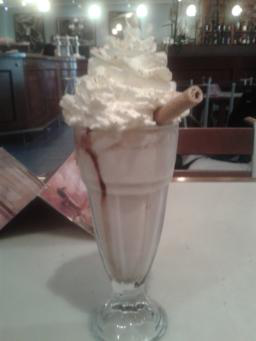
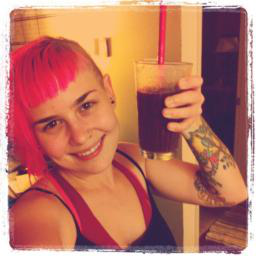
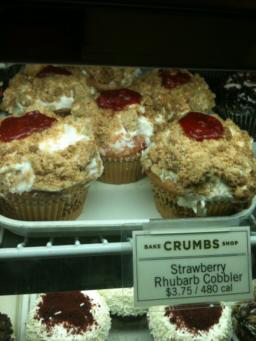
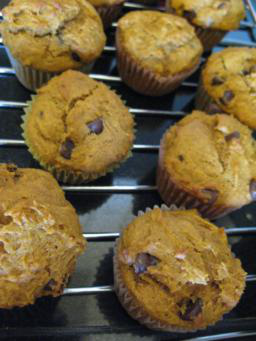
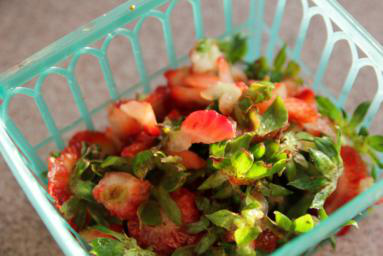

In [12]:
imgs_filtered = imgs_with_pred[(imgs_with_pred["probability"] > 0.9) &
                 (imgs_with_pred["label"] != imgs_with_pred["class"] )]
imgs_filtered.explore()

Here we can see the probability for each category (ordered alphabetically):

In [13]:
predictions = model.predict(test_data, output_type="probability_vector")
print("Probabilities for 1st image", predictions[0])

Probabilities for 1st image array('d', [0.23008658662108616, 0.00015908525165530564, 0.00749614259019676, 0.053517240418048256, 0.00046873653205304407, 0.09199293491548469, 0.09057741664543856, 0.0005872675324627722, 0.005341966837151099, 0.0009858681338006546, 0.19014834454248644, 0.01902947597465011, 0.0016182238900356006, 0.0051908038865093814, 0.0808026848337731, 0.00897434801447145, 0.0002465803922821658, 0.11014391838647625, 0.05602854556052163, 0.0466038290414166])


But this validation is using a random subset of images, we can also use our own validation set, with this we can ensure that we have very different images that will give a better result:

In [ ]:
val_data = tc.image_analysis.load_images("/content/gdrive/MyDrive/Colab Notebooks/snacks/val", with_path=True)
val_data["label"] = val_data["path"].apply(lambda path:
      os.path.basename(os.path.split(path)[0]))
len(val_data)

model = tc.image_classifier.create(train_data, target="label",
                                   model="squeezenet_v1.1",
                                   verbose=True, max_iterations=100,
                                   validation_set=val_data)

After adding my own validation data, I can create a confusion matrix, this plots the predicted classes vs the real class labels, helping with visualizing where the model tends to make mistakes:

In [17]:
print("Confusion Matrix:\n", metrics["confusion_matrix"])

Confusion Matrix:
 +--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|  strawberry  |      candy      |   4   |
|  watermelon  |      juice      |   4   |
|    salad     |      grape      |   2   |
|    salad     |      carrot     |   5   |
|  pineapple   |    ice cream    |   1   |
|    candy     |      orange     |   2   |
|     cake     |    watermelon   |   1   |
|    muffin    |      candy      |   1   |
|     cake     |      cookie     |   3   |
|   popcorn    |     popcorn     |   25  |
+--------------+-----------------+-------+
[216 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


Performing feature extraction on resized images...
Completed  64/986
Completed 128/986
Completed 192/986
Completed 256/986
Completed 320/986
Completed 384/986
Completed 448/986
Completed 512/986
Completed 576/986
Completed 640/986
Completed 704/986
Completed 768/986
Completed 832/986
Completed 896/986
Completed 960/986
Completed 986/986


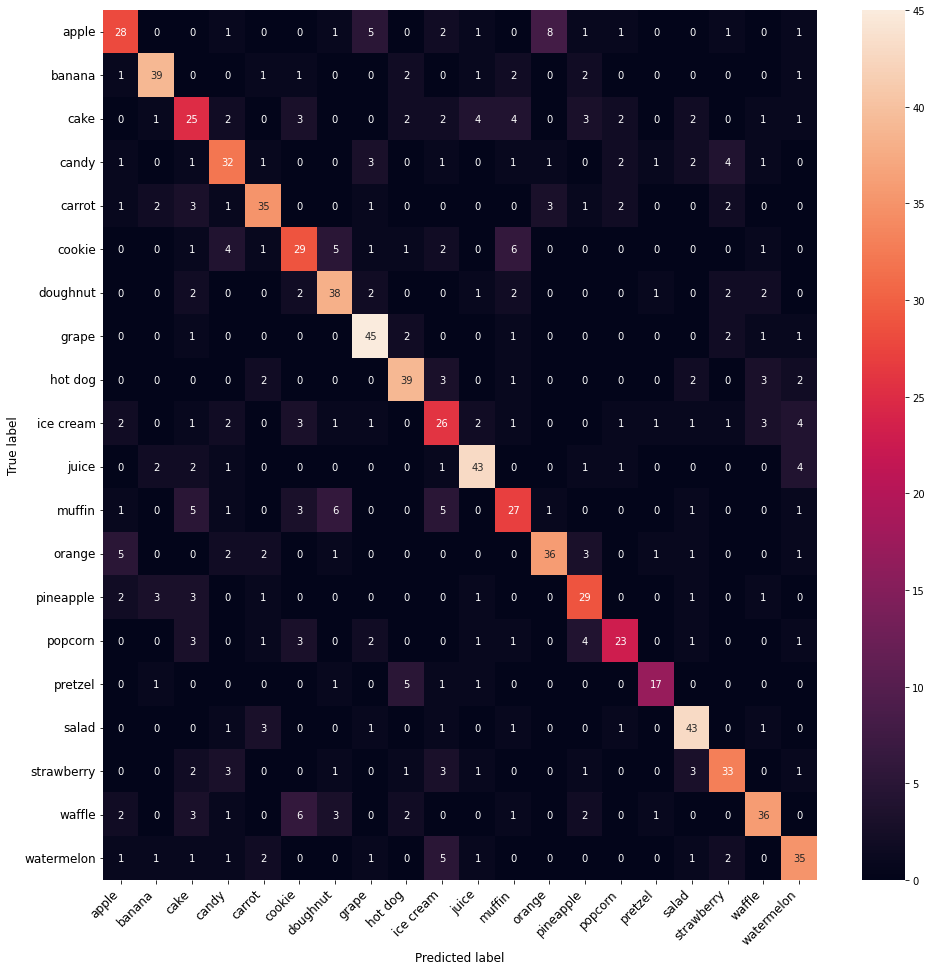

In [23]:
import numpy as np
import seaborn as sns

metrics = model.evaluate(test_data)
labels = test_data["label"].unique().sort()

def compute_confusion_matrix(metrics, labels):
    num_labels = len(labels)
    label_to_index = {l:i for i,l in enumerate(labels)}

    conf = np.zeros((num_labels, num_labels), dtype=int)
    for row in metrics["confusion_matrix"]:
        true_label = label_to_index[row["target_label"]]
        pred_label = label_to_index[row["predicted_label"]]
        conf[true_label, pred_label] = row["count"]

    return conf

def plot_confusion_matrix(conf, labels, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(conf, annot=True, fmt="d")
    heatmap.xaxis.set_ticklabels(labels, rotation=45,
                                 ha="right", fontsize=12)
    heatmap.yaxis.set_ticklabels(labels, rotation=0,
                                 ha="right", fontsize=12)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)
    plt.show()

conf = compute_confusion_matrix(metrics, labels)
plot_confusion_matrix(conf, labels, figsize=(16, 16))

This confusion matrix shows that the model learned a great deal, although not yet perfect (the goal would be to have 0s everywhere except the central diagonal line). Actually, there's much to improve, as the sum of the numbers outside the diagonal line adds up to over 300 missclassified images!

Computing the recall for each class:
evaluate() gave us the overall accuracy, but it's best to check accuracy for each class. Here we can see how banana and grape are very accurate, whereas cake, ice cream, and muffin are not as good. Again, this could be solved with more and/or better data

In [20]:
for i, label in enumerate(labels):
    correct = conf[i, i]
    images_per_class = conf[i].sum()
    print("%10s %.1f%%" % (label, 100. * correct/images_per_class))

     apple 54.0%
    banana 80.0%
      cake 48.1%
     candy 51.0%
    carrot 68.6%
    cookie 60.8%
  doughnut 63.5%
     grape 81.1%
   hot dog 73.1%
 ice cream 44.0%
     juice 76.4%
    muffin 49.0%
    orange 71.2%
 pineapple 63.4%
   popcorn 62.5%
   pretzel 61.5%
     salad 75.0%
strawberry 69.4%
    waffle 64.9%
watermelon 60.8%


Another way to improve the model is to regularize it. This means to punish weights that are too big:

In [ ]:
model = tc.image_classifier.create(train_data, target="label",
                                   model="squeezenet_v1.1",
                                   verbose=True, max_iterations=200,
                                   validation_set=val_data,
                                   l2_penalty=10.0, l1_penalty=0.0,
                                   convergence_threshold=1e-8)

The training accuracy might not go as high as before, but the validation accuracy doesn't drop either. I could continue to fine tune l2_penalty and l1_penalty (hyperparameter tuning). But I found 10.0 and 0.0 to be good enough. The model is ready to be exported and used:

In [ ]:
model.export_coreml("MultiSnacks_regularized.mlmodel")